In [1]:
# gesture_recog.ipynb

# The model is to train the guesture of images with the Leap Motion 
# T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared 
# Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision
# Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)

# Please download the leapgestrecog dataset from Kaggle. 
# https://www.kaggle.com/gti-upm/leapgestrecog

In [2]:
# Set up the GPU growth to avoid the sudden runtime error.

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt
from alexnet import AlexNet
from keras.models import load_model
from keras import models

from keras.preprocessing import image
import numpy as np
import datetime
import os
import shutil
from PIL import Image
from numba import cuda

In [4]:
# Move the iamges from the original path to the source path 

orig_dir = '/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog'
src_dir  = '/home/mike/Documents/image_gesture/leapgestrecog/src_data'
if not os.path.exists(src_dir):
    os.makedirs(src_dir)

def move_data(orig_dir, src_dir):

    # Conduct three iterations with i, j and k counters
    for i in os.listdir(orig_dir):
        label = 0
        # Get the original category(ca) with i pointing to any folder from 00 to 09
        origca_dir = os.path.join(orig_dir, i)
        print("[INFO]Category：%s %s"% (origca_dir,i))
        
        # The counter j points to any folder from 01_palm to 10_down. 
        for j in os.listdir(origca_dir):
            # The label is related to str(label) in the k iterations. 
            label = label + 1
            # Create the origcaty_dir.Type(ty) represents the type of the above folders
            origcaty_dir = os.path.join(origca_dir, j)
            print("[INFO]Type：%s %s"% (origcaty_dir,j))
            
            for k in os.listdir(origcaty_dir):
                # origimg_path is the absolute path that holds the images such as frame_00_7_0001.png
                origimg_path = os.path.join(origcaty_dir, k)
                # Create the diretort for the label with str(label) ranging from 1 to 10
                srclbl_dir = os.path.join(src_dir, str(label))
                if not os.path.exists(srclbl_dir):
                    os.makedirs(srclbl_dir)
                # Create the absolute path 
                srcimg_path = os.path.join(srclbl_dir, k)
                 # Move the images 
                shutil.move(origimg_path, srcimg_path)
                
        print("[INFO]One Person Finished：", origcaty_dir)
        
    print("[INFO]All Finished!")

move_data(orig_dir, src_dir)

[INFO]Category：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06 06
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/03_fist 03_fist
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/08_palm_moved 08_palm_moved
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/06_index 06_index
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/09_c 09_c
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/10_down 10_down
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/01_palm 01_palm
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/05_thumb 05_thumb
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/02_l 02_l
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/04_fist_moved 04_fist_moved
[INFO]Type：/home/mike/Documents/image_gesture/leapgestrecog/lea

In [5]:
# Divide the dataset into train, validation and test sets. 

# Designate source and division datasets
src_dir = '/home/mike/Documents/image_gesture/leapgestrecog/src_data'
dset_dir = '/home/mike/Documents/image_gesture/dset_data'
if not os.path.exists(dset_dir):
    os.makedirs(dset_dir)

if not os.path.exists(dset_dir):
    os.makedirs(dset_dir)

# Make three directories for training, validation and test
train_dir = os.path.join(dset_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
validation_dir = os.path.join(dset_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)  

test_dir = os.path.join(dset_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

    
for num in os.listdir(src_dir):
    # Folder 1~10
    train_idx_dir = os.path.join(train_dir, num)
    if not os.path.exists(train_idx_dir):
        os.mkdir(train_idx_dir)
        
    validation_idx_dir = os.path.join(validation_dir, num)
    if not os.path.exists(validation_idx_dir):
        os.mkdir(validation_idx_dir)
        
    test_idx_dir = os.path.join(test_dir, num)
    if not os.path.exists(test_idx_dir):
        os.mkdir(test_idx_dir)
        
    # Index is increasing. 
    src_idx_dir = os.path.join(src_dir, num)
    
    # print(src_idx_dir)

    j = 0
    
    for fname in os.listdir(src_idx_dir): 
        
        if j < 1000:  # Copy 1000 images to the train directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(train_idx_dir, fname)
            shutil.copyfile(src, dst)
        elif (j >= 1000 and j < 1500):  # Copy 500 images to the val directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(validation_idx_dir, fname)
            shutil.copyfile(src, dst)
        elif (j >= 1500):  # Copy 500 images to the test directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(test_idx_dir, fname)
            shutil.copyfile(src, dst)
            
        j = j + 1
        
    print("[INFO]Copy finished! :", train_idx_dir)
    print("[INFO]Copy finished! :", validation_idx_dir)
    print("[INFO]Copy finished! :", test_idx_dir)


print('[INFO]training files:', len(os.listdir(train_dir)))
print('[INFO]validation files:', len(os.listdir(validation_dir)))
print('[INFO]test files:', len(os.listdir(test_dir)))

print('[INFO]1 training images:', len(os.listdir(train_dir+"/1/")))
print('[INFO]1 validation images:', len(os.listdir(validation_dir+"/1/")))
print('[INFO]1 test images:', len(os.listdir(test_dir+"/1/")))

[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/3
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/3
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/3
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/10
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/10
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/10
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/5
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/5
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/5
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/train/7
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/validation/7
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/test/7
[INFO]Copy finished! : /home/mike/Documents/image_gesture/dset_data/t

In [6]:
# Assign the global arguments 
EPOCHS = 32
BATCH_SIZE = 64
image_width = 150
image_height = 150
channels = 3
num_classes = 1

In [7]:
# Call the cnn/alexnet model 
model = AlexNet((image_width,image_height,channels), num_classes)

# Model configuration
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

# Summary
model.summary

<bound method Network.summary of <alexnet.AlexNet object at 0x7fc37b595990>>

In [8]:
# Preprocess the images

train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_width,image_height),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')
train_num = train_generator.samples

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(image_width,image_height),
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='binary')
val_num = validation_generator.samples


test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(test_dir,
                                                   target_size=(image_width,image_height),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary')
test_num = test_generator.samples

Found 10000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [9]:
# Model configuration

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

In [10]:
# Get the batch shape

for data_batch, label_batch in train_generator:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", label_batch)
    
    break

data batch shape: (64, 150, 150, 3)
labels batch shape: [5. 8. 0. 7. 6. 2. 4. 5. 4. 4. 5. 2. 2. 8. 5. 4. 3. 0. 7. 2. 2. 8. 4. 7.
 4. 5. 3. 0. 1. 1. 8. 0. 0. 7. 8. 8. 8. 0. 3. 4. 3. 0. 9. 2. 9. 1. 9. 1.
 1. 1. 3. 8. 3. 6. 0. 0. 2. 1. 0. 1. 5. 9. 1. 4.]


In [11]:
# Set the tensorboard 

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]

In [12]:
# 8.Tain the model
history = model.fit(train_generator,
                    steps_per_epoch=train_num//BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=validation_generator,
                    validation_steps=val_num//BATCH_SIZE)

Epoch 1/32
156/156 [==============================] - 19s 121ms/step - loss: -53.4414 - acc: 0.0997 - val_loss: -53.3265 - val_acc: 0.1002
Epoch 2/32
156/156 [==============================] - 19s 120ms/step - loss: -53.3616 - acc: 0.1002 - val_loss: -53.3387 - val_acc: 0.1002
Epoch 3/32
156/156 [==============================] - 19s 120ms/step - loss: -53.3524 - acc: 0.0998 - val_loss: -53.3846 - val_acc: 0.1000
Epoch 4/32
156/156 [==============================] - 18s 117ms/step - loss: -53.4506 - acc: 0.0991 - val_loss: -53.3998 - val_acc: 0.1000
Epoch 5/32
156/156 [==============================] - 18s 117ms/step - loss: -53.3355 - acc: 0.1014 - val_loss: -53.3326 - val_acc: 0.1002
Epoch 6/32
156/156 [==============================] - 18s 117ms/step - loss: -53.3493 - acc: 0.0997 - val_loss: -53.3662 - val_acc: 0.0998
Epoch 7/32
156/156 [==============================] - 18s 117ms/step - loss: -53.3984 - acc: 0.0997 - val_loss: -53.3907 - val_acc: 0.0998
Epoch 8/32
156/156 [=======

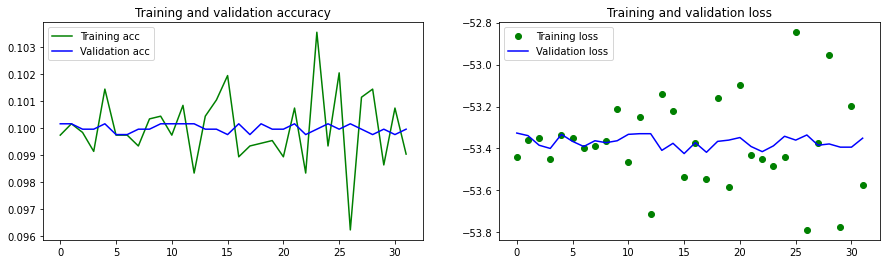

In [13]:
# Evaluate the model with visulizing the result 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss', color='green')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

(1, 150, 150, 3)


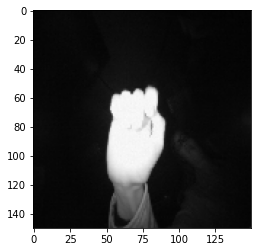

The 1st layer network size： (1, 35, 35, 96)


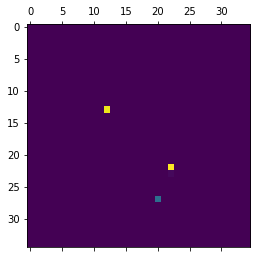

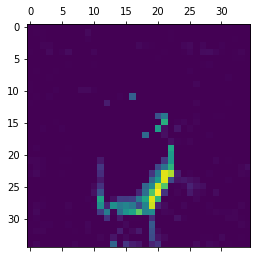

In [14]:
# Preprocess the image into a 4D tensor

# Prepare a path for a specific image 
img_path = '/home/mike/Documents/image_gesture/dset_data/test/1/frame_00_03_0001.png'

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# The model was trained on the inputs that were preprocessed as follows. 
img_tensor /= 255.

# The shape is (1, 150, 150, 3)
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation=activations[0]
print('The 1st layer network size：',first_layer_activation.shape)

# The third channel
plt.matshow(first_layer_activation[0,:,:,3],cmap="viridis")
plt.show()

# The tenth channel
plt.matshow(first_layer_activation[0,:,:,30],cmap="viridis")
plt.show()

In [15]:
# Release the GPU memory 

cuda.select_device(0)
cuda.close()